In [3]:
using Interact, Plots, DifferentialEquations, LinearAlgebra, BifurcationKit, Setfield
using NonLinearDynamicsCourse

WebIO._IJuliaInit()

# Flujos2D

Vamos a ver algunos modelos no lineales sencillos y "clasicos" para estudiarlos numericamente. En la segunda parte vamos a calcular de forma mas analítica los puntos fijos y su estabilidad (y por ende sus posibles bifurcaciones), pero por ahora vamos a explorarlos de forma interactiva

# Modelo de Predador-Presa Lotka Volterra

Los modelos de dinamica de poblaciones en 1D se pueden escribir de forma general como 

$\dot{x} = R(x) x$

donde $R(x)$ es la tasa de reproduccion y extincion de la especie. Por ejemplo $R(x)=R(1-x/K)$ para la ecuacion logistica o $R=R(1-x/K)-\frac{x}{1+x^2}$ para la logistica con outbreak. Si ahora tenemos dos especies y una preda a la otra podemos esperar de forma general que la tasa de reproduccion y extincion dependa de ambas poblaciones, es decir:

$\dot{x} = R(x,y) x$

$\dot{y} = S(x,y) y$

De forma independiente Vito Volterra (1926) y Alfred Lotka (en realidad estudiando un modelo para las reacciones autocataliticas), propusieron la siguiente forma sencilla para la tasa de crecimiento de la presa $R(x-y)=b-cy$ donde $b$ es la tasa de crecimiento de la especie y $c$ es el impacto de la predación. Notar que el crecimiento no depende de los predadores pero su extincion si. Mientras que para la poblacion de predadores sucede a la inversa, su crecimiento depende de la existencia de presa (podemos pensar que aumenta la capacidad del sistema) mientras que su extincion no (es fija por muerte natural). En ese caso $S(x,y)=ax-d$.

Las ecuaciones de Lotka Volterra son entonces

$\dot{x} = (b-cy)x$

$\dot{y} = (ax-d)y$

Notar que hay terminos lineales: $bx$ crecimiento de la poblacion de presa, $-dy$ extincion de la poblacion de predadores que no dependen de la interaccion. Y por otro lado hay dos terminos que dependen de la interaccion, es decir del producto entre las dos poblaciones: $-cxy$ el impacto de la predacion en la poblacion de presa, y $axy$ el impacto de la poblacion de presa (recursos disponibles) en la capacidad de la poblacion de predadores.

Los puntos fijos son aquellos $(x,y)$ que hacen que **ambas** ecuaciones se hagan cero. Vamos a ver mas adelante como calcularlos pero por ahora se puede ver por simple inspeccion que un punto fijo es el $(0,0)$ porque cuando $x=0$ la primera ecuacion se anula y cuando $y=0$ se anula la segunda. Esto tiene sentido, si no hay predadores ni presas el sistema no evoluciona. 

El otro punto fijo va a darse cuando los valores de $(x,y)$ anulen los parentesis es decir cuando $x=d/a$  $y=b/c$. Este es un punto de equilibrio que mas adelante vamos a poder determinar que es un centro. Todas las soluciones son orbitas cerradas entorno a este equilibro. Es decir que el modelo de Lotka Volterra lleva a la oscilacion de las poblaciones, algo que se observa en muchos sistemas simples.

Los valores de los parametros son siempre positivos, pero ademas hay dos parametros ($a$ y $c$) que no pueden ser cero porque harian "explotar" el sistema (el centro se mueve a infinito).

In [ ]:
function volterra!(du,u,p,t)
    (a,b,c,d) = p
    du[1] = (b-c*u[2])*u[1]
    du[2] = (a*u[1]-d)*u[2]
    du
end    

In [ ]:
@manipulate throttle=.05 for u1=0:0.1:1,u2=0.1:0.1:1,a=0.1:0.1:1,b=0:0.1:1,c=0.1:0.1:1,d=0:0.1:1
    sol = solve(ODEProblem(volterra!, [u1; u2], (0, 100), [a,b,c,d]));
    p1 = plot(sol)
    p2 = plot(sol,vars=(1,2),arrow=true)
    plot(p1,p2,layout=(1,2),size = (900,450))
end

In [ ]:
# Multiples trayectorias
u0_arr=0.05:0.05:1.0
a=0.5;b=0.5;c=0.5;d=0.5
function prob_func(prob,i,repeat)
  remake(prob,u0=[u0_arr[i];b/c])
end
prob = ODEProblem(volterra!,[0.1; b/c], (0, 30), [a,b,c,d]);
sol = solve(EnsembleProblem(prob,prob_func=prob_func),
    EnsembleThreads(),trajectories=length(u0_arr))
plot(sol,vars=(1,2),color=:black,linewidth=0.2,size = (600,500))

# Modelo simple de epidemia. SIR

EL modelo mas simple de propagacion de epidemia (propuesto en 1927 por Kermack & McKendrik) considera una poblacion  constante dividida en tres "compartimentos": los Suceptibles $S$ (individuos que pueden contagiarse), los Infectados $I$, y los Recuperados $R$ que no se vuelven a contagiar. Como la suma de los tres es constante en realidad se trata de un modelo 2D, pero lo usual es escribir las ecuaciones diferenciales para las tres poblaciones:

$\dot{S} = -\beta SI$

$\dot{I} = \beta SI - \gamma I$

$\dot{R} = \gamma I$

donde usamos la poblacion normalizada ($S+I+R=1$). Como $R$ no aparece en las dos primeras ecuaciones podemos resolver esas dos primeras y luego calcular $R=1-S-I$

Este es un sistema bastante particular porque $I=0$ anula las tres ecuaciones, con lo cual hay "infinitos" puntos fijos sobre esa recta. Esto quiere decir que el estado final depende de los parametros y el valor inicial pero puede ser cualquier punto sobre esa recta (va a depender de la historia del sistema).

In [ ]:
function sir!(du,u,p,t)
    du[1] = -p[1]*u[1]*u[2]
    du[2] = p[1]*u[1]*u[2]-p[2]*u[2]
    du
end    

In [ ]:
@manipulate throttle=0.5 for i=0:0.01:1, β=0:0.01:1,γ=0:0.01:1,tmax=10:10:500
    sol = solve(ODEProblem(sir!, [1.0-i; i], (0, tmax), [β,γ]));
    p1 = plot(sol,vars=(0,1),label="Suceptibles")
    plot!(p1,sol,vars=(0,2),label="Infectados")
    plot!(p1,sol,vars=((t,x,y)->(t,1-x-y),0,1,2),label="Recuperados")
    p2 = plot(sol,vars=(1,2),arrow=true)
    plot(p1,p2,layout=(1,2),size = (900,450))
end   

Probar que pasa con una tasa de recuperacion de diez dias ($\gamma = 0.1$) y una tasa de transmision maxima ($\beta  = 1$. Aun con una cantidad de infectados inicial del $1\%$ se llega a un pico de infectados de casi el $70\%$ antes de los 10 dias. Si se disminuye la tasa de contagio (por ejemplo restringiendo los contactos mediante una cuarentena) baja el valor de $\beta$ y se aplana la curva.

# Modelo de Predador-Presa mas realista

Si bien el modelo de Lotka-Volterra es no lineal, no presenta una caracteristica generica de muchos sistemas que es la **estabilidad estructural**, es decir que el flujo no cambie cualitativamente para pequeñas perturbaciones. Por ejemplo las soluciones dependen de la condicion inicial y si en algun momento perturbamos una orbita, saltamos a la de al lado y nunca volvemos a la orbita original (algo que sucede en sistemas conservativos pero que no es muy util para dinamica de poblaciones o sistemas naturales con disipacion donde las soluciones suelen ser robustas o estructuralmente estables).

Para empezar podemos reemplazar el termino de crecimiento exponencial $bx$ de la presa por un crecimiento logistico con una capacidad $K$. Luego en lugar de asumir que el impacto de la predacion en la poblacion de la presa es siempre proporcional al producto de la presa por el predador podemos asumir que satura en un momento determinado (el predador no es insaciable). Si $N$ es la poblacion de la presa y $P$ la del predador la ecuacion para la varicion de la poblacion de la presa seria:

$\dot{N}=RN \displaystyle \left( 1-  \frac{N}{K} \right) - PNf(N)$

Con $f(N)$ una funcion que satura, vamos a tomar una forma simple $f(N) = A/(N+C)$.

Por otro lado podemos suponer simplemente para la poblacion del predador $P$ un crecimiento logistico donde la capacidad es proporcional a la poblacion de la presa con lo cual la segunda ecuacion quedaria:

$\dot{P}=SP\displaystyle \left(1-\frac{P}{BN}\right)$

Tenemos seis parametros ($R,S,K,A,B,C$), pero se pueden reducir si adimensionalizamos las poblaciones: $x=N/K$ $y=P/(BK)$. Al principio las ecuaciones se complican (dividimos la de arriba por $K$ y la de abajo por $BK$):

$\displaystyle\frac{d(N/K)}{dt}=\displaystyle\frac{RN}{K} \displaystyle \left( 1-  \frac{N}{K} \right) - \displaystyle\frac{PAN}{K^2(N/K+C/K)}$

$\displaystyle\frac{d(P/(BK))}{dt}= \displaystyle\frac{SP}{BK}\displaystyle \left(1-\frac{P}{BN}\right)$

reemplazando por la definición de las variables adimensionalizadas y reescalando el tiempo por $\tau=t/R$:

$\displaystyle\frac{dx}{d\tau}=x\displaystyle \left( 1-  x \right) - \displaystyle\frac{ABxy}{R(x+C/K)}$

$\displaystyle\frac{dy}{dt}= \displaystyle\frac{S}{R}y\displaystyle \left(1-\frac{y}{x}\right)$


si redefinimos parametros: $a=AB/R$, $b=S/R$, $c=C/K$ las ecuaciones para las poblaciones adimensionalizadas de presa ($x$) y predador ($y$) quedan escritas de una forma mas compacta (ahora el punto es la derivada con respecto a $\tau$):

$\dot{x} = x(1-x)-\displaystyle \frac{axy}{x+c}$

$\dot{y} = by\displaystyle \left( 1-\frac{y}{x}\right)$

que depende solo de tres parametros $a,b,c$. La contra es que ahora los parametros son mas dificiles de interpretar. Por ejemplo $b$ representa como es la tasa de crecimiento de la poblacion de predadores **relativa** a la tasa de crecimiento de la poblacion de presas, $c$ esta vinculada a la fraccion de la poblacion maxima de presa a la que satura la predacion, pero $a$ es mas dificil de interpretar ya que crece tanto con la accion de la predacion como con la capacidad de la poblacion de los predadores relativa a la capacidad de la poblacion de la presa.

Mas adelante vamos a calular los puntos fijos y la estabilidad, pero una caracteristica que se puede observar es que hay dos regimenes. Para un valor fijo de $a>0.5$ las dos poblaciones llegan a un punto fijo con un mismo valor $x=y$ para valores de $b$ y $c$ altos, pero si esto parametros disminuyen las poblaciones comienzan a oscilar. A diferencia del modelo de Lotka-Volterra, esta oscilacion es estructuralmente estable, todas las trayectorias convergen a esa oscilacion que se conoce como **ciclo limite**. 

In [ ]:
function predatorprey!(du,u,p,t)
    du[1] = u[1]*((1.0-u[1]) - p[1]*u[2]/(p[3]+u[1]))
    du[2] = p[2]*u[2]*(1.0-u[2]/u[1])
    du
end    

In [ ]:
@manipulate throttle=0.5 for u1=0.1:0.1:1,u2=0.1:0.1:1,a=0.01:0.01:1.0,b=0.01:0.01:1.0,c=0.01:0.01:1.0,tmax=10:10:500
    sol = solve(ODEProblem(predatorprey!, [u1; u2], (0, tmax), [a,b,c]));
    p1 = plot(sol)
    p2 = plot(sol,vars=(1,2),arrow=true)
    plot(p1,p2,layout=(1,2),size = (900,450))
end   

In [ ]:
# Multiples trayectorias
u0_arr = vec([[0.1*i,0.1*j] for i=1:10, j=1:5])
a=0.9;b=0.1;c=0.1
function prob_func(prob,i,repeat)
  remake(prob,u0=u0_arr[i])
end
prob = ODEProblem(predatorprey!,[0.1; 0.3], (0, 100), [a,b,c]);
sol = solve(EnsembleProblem(prob,prob_func=prob_func),
    EnsembleThreads(),trajectories=length(u0_arr))
plot(sol,vars=(1,2),linewidth=0.2,color=:black,size = (600,300))

# Oscilador de Duffing
 Asi como el Oscilador armónico (sistema lineal) se puede ver como el movimiento unidimensional de una particula en un pozo. El oscilador de Duffing corresponde al movimiento en un doble pozo (que de todas formas mediante un cambio de parametro se puede volver de pozo simple pero sin dejar de ser no lineal). 

<div>
<img src="../files/single_double_well.png" width="500px">
</div>
 
Un sistema fisico (si bien algo artificial) que tiene este comportamiento se puede armar con una lengueta metalica flexible puesta entre dos imanes:
<div>
<img src="../files/duffing.png" width="300px">
</div>

Si la potencia de los imanes no supera la rigidez de la lengueta tenemos la situacion de un unico pozo (si bien no es una oscilacion libre por la presencia de los imanes) y hay un solo atractor (el centro). Si la rigidez baja (o los imanes se acercan, o se ponen imanes mas potentes) hay dos situaciones de equilibrio estable (apuntando a uno u otro iman) separados por un punto inestable (que como vamos a ver mas adelante es un punto silla).

Las ecuaciones del oscilador de Duffing son las siguientes:

$\dot{x} = y$

$\dot{y} = -\gamma y + \beta x -  x^3$

En el caso de la lengueta con los imanes $x$ es la posicion horizontal de la punta, $y$ la velocidad (de ahi la primera ecuacion diferencial), $\gamma$ es la disipacion del aire y la friccion (igual que en el caso del resorte es una fuerza que se opone a la velocidad) y en $\beta$ esta resumida la relacion entre la fuerza de los imanes y la rigidez de la lengueta. Si $\beta$ es positivo ganan los imanes y si es negativo gana la rigidez. Notar que el termino cubico es el que termina ganando siempre, muy lejos del equilibro la fuerza es siempre atractiva, por lo tanto el sistema no va a explotar.

Este sistemita simple al ser forzado periodicamente presenta CAOS!

## Puntos fijos Oscilador de Duffing
Vamos a calcular los puntos fijos primero por el metodo de las nulclinas.

La primera nuclina es trivial, me da una recta horizontal $y=0$ con lo cual todos los puntos fijos van a estar sobre el eje $x$

La segunda nulclina se resuelve en una ecuacion cubica para $y$ en funcion de $x$:

$y = (\beta x - x^3)/ \gamma $

y recordemos que una cubica podia tener forma de "N" si el termino lineal y cubico tenian signo diferente ($\beta > 0$) o una doble curva suave si tenian el mismo signo ($\beta < 0$). $\gamma$ actua solo como factor de escala haciendo mas alta o mas baja la "N". 

<div>
<img src="../files/cubic.png" width="500px">
</div>

En este caso si bien usamos el metodo de las nulclinas como de la primera ecuacion sabemos que $y=0$ los puntos fijos van a ser las raices de esta cubica, es decir donde corte el eje horizontal. Por lo tanto basta con resolver 

$\beta x = x^3$

que tiene una solucion trivial $x^*_1=0$ y despues, solo para el caso de $\beta>0$ dos soluciones simetricas (que se obtienen dividiendo ambos miembros de la ecuacion anterior por $x$ ya que es diferente de 0) en 

$x^*_{2,3} = \pm \sqrt{\beta}$

In [ ]:
#definimos la Ed para el oscilador de Duffing
function duffing!(du,u,p,t)
    du[1] = u[2]
    du[2] = -p[1]*u[2]+u[1]*(p[2]-u[1]*u[1])
    du
end    

flux2d_nullclines(duffing!,[0.12;0.2],50.0,[0.1,0.5];ylims=[-1.5,1.5])

Notar que en este caso tenemos tres puntos fijos, por el ordenamiento de las regiones podemos saber que es un foco, un punto silla y un foco. 

In [ ]:
@manipulate throttle=0.5 for x0=-1:0.1:1, y0=-1:0.1:1,β=-1.0:0.1:1.0,γ=0:0.01:1.0
    flux2d_nullclines(duffing!,[x0;y0],50.0,[γ,β];ylims=[-1.5,1.5])
end    

In [ ]:
u0_arr = vec([[-1+i*0.5,-1+j*0.5] for i=0:5, j=0:5])
flux2d_nullclines(duffing!,u0_arr,5.0,[0.5,0.5])

# Flujos 2D, Linealizacion, Estabilidad

Los puntos fijos de un sistema dinámico no-lineal 2D pueden ser de forma general de tipo silla, nodo/foco atractor/repulsor o centros, al igual que los sistemas lineales. Esto es porque MUY cerca (arbitrariamente cerca para ser mas precisos) del punto fijo el campo vector se puede aproximar como un sistema lineal. 

Recordemos que para flujos 1D $\dot{x}=f(x)$ el sistema linealizado era simplemente $\dot{x}=f'(x_*)(x-x_*)$, es decir que el coeficiente era la derivada del campo vector $f(x)$ evaluada en el punto fijo $x_*$. Habiamos mostrado esto con el desarrollo de Taylor de la función en un entorno del punto fijo.

Para flujos 2D el sistema linealizado va a estar dado por una matriz que se obtiene del desarrollo de Taylo de una función vectorial de dos variables. Nos vamos a ahorrar escribir ese desarrollo y vamos a indicar que el equivalente de la derivada ordinaria $f'(x)$ para una funcion vectorial (el campo vector) de dos variables es una matriz compuesta por las derivadas parciales del campo vector $[f(x,y),g(x,y)]$ de la siguiente forma:

${\bf J}(x,y) =
\begin{pmatrix}
\displaystyle\frac{\partial f}{\partial x} & \displaystyle\frac{\partial f}{\partial y}\\
\displaystyle\frac{\partial g}{\partial x} & \displaystyle\frac{\partial g}{\partial y}
\end{pmatrix}$

esta matriz $J$ es tambien conocida como el **Jacobiano** del campo vector $[f,g]$, y en principio es una función de $(x,y)$ como el campo vector. De hecho podriamos decir que es la **derivada del campo vector en dos dimensiones**

El sistema linealizado va a estar dado por la matriz Jacobiana evaluada en el punto fijo:

$\dot{\bf{u}} = \bf{J}(\bf{u_*})(\bf{u}-\bf{u_*})$

Para evaluar la estabilidad del punto fijo tenemos que calcular los autovalores de $bf{J}(\bf{u_*})$ y utilizar los mismos criterios que para los sistemas lineales.

En sintesis, el método de análisis de los flujos no lineales 2D consta de los siguientes pasos:

1. Calcular y/o graficar las nuclinas $f(x,y)=0$ $g(x,y)=0$
2. Determinar los puntos fijos $(x_*,y_*)$ a partir del cruce de las nulclinas
3. Calcular la matriz Jacobiana ${\bf J}(x,y)$ a partir de las derivadas parciales del campo vector
4. Evaluar la matriz Jacobiana en cada uno de los puntos fijos ${\bf J}(x_*,y_*)$
5. Para cada uno de los puntos fijos calcular la traza y el determinante de ${\bf J}(x_*,y_*)$ para determinar a que clase pertenece (nodo/foco repulsor/atractor o punto silla, o eventualmente centro)
6. Para los puntos silla determinar las direcciones de los autovectores y evolucionar condiciones inciales en esa direccion en un entorno del punto fijo hacia adelante en el tiempo para las direcciones inestables y hacia atrás en el tiempo para las estables.

El último paso es la generalización del análisis que hacíamos de las autodirecciones estables como "divisorias de aguas" para los sistemas lineales y corresponde al calculo de las **variedades estable e inestable** del punto silla que vamos a ilustrar primero con un ejemplo concreto.

# Análisis de sistema minimal con nolinealidad cuadrática


Vamos a empezar con un sistema con la nolinealidad más simple posible (un solo término cuadrático) dependiente de un parámetro $a>0$:

$f(x,y) = a-y$

$g(x,y) = x^2-y$

Las primera nulclina es el eje horizontal $y=a$ y la segunda es una parábola que pasa por el origen $y=x^2$.
Estas nulclinas se cortan en dos puntos $x=\pm\sqrt{a}$. 

Veamos primero las nulclinas y el campo vector:

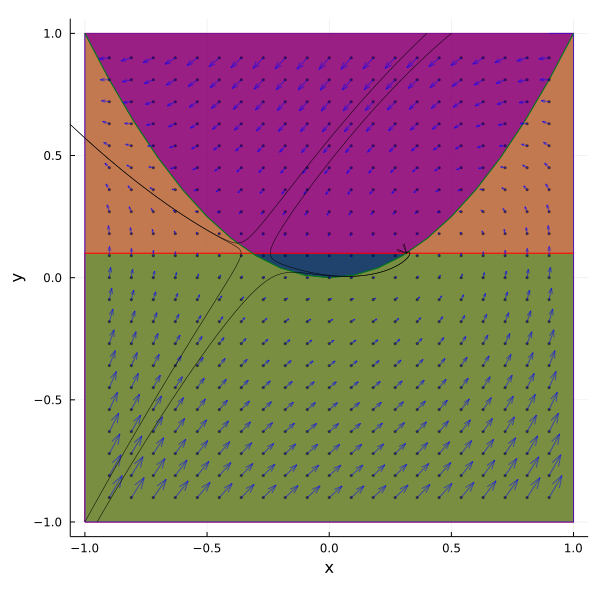

In [30]:
function cuad!(du,u,p,t)
    du[1]=p[1]-u[2]
    du[2]=u[1]*u[1]-u[2]
    du
end
u0_arr=[[-1.0;-1.0],[-0.95;-1.0],[0.4;1.0],[0.5;1.0]]
flux2d_nullclines(cuad!,u0_arr,30.0,[0.1];vectorfield=true,size=(600,600))

Además del campo vector y las nulclinas evolucionamos cuatro condiciones iniciales. Evolucionar distintas condiciones iniciales nos sirve también para hacer un primer estudio exploratorio y entender cómo está organizado el flujo global. En toda la región inferior $y<0$ excluyendo la parábola el flujo va hacia arriba y la derecha. 

La parte de flujo que pasa por la derecha de la parábola se mete en la zona naranja que tuerce el flujo hacia la izquierda y lo hace entra en la magenta que lo tuerce para abajo, es decir que de forma global esta porcion de flujo se enrolla en sentido antihorario. De esa parte de flujo "enrollado" hay a su vez una porcion que pasa a la zona cyan que vuelve a torcer el flujo a la derecha y termina de dar un giro completo en torno al punto fijo de la derecha. Esto ya hace presuponer que ese punto fijo es un foco. Lo que está en la region magenta y no entra en la zona cyan pasa a la naranja que lo "endereza" otra vez hacia arriba y ya no vuelve a entrar en la zona verde y se escapa.

En cambio la parte de flujo que pasa por la izquierda de la parabola pasa por la zona naranja de la izquierda y se tuerce a la izquierda y se aleja juntandose con el flujo "enderezado" que vino de la region magenta. Esto último hace presuponer que el punto fijo de la izquierda es un saddle (punto silla). 

Calculamos cada una de las derivadas

$\frac{\partial f}{\partial x}=0 \quad$  ya que $f$ no depende de x

$\frac{\partial f}{\partial y}=-1 \quad$  ya que la derivada de una funcion lineal es la pendiente

$\frac{\partial g}{\partial x}=2x \quad$  la derivada de la funcion cuadratica $x^2$ es $2x$

$\frac{\partial g}{\partial y}=-1 \quad$  ya que la derivada de una funcion lineal es la pendiente

La matriz Jacobiana es entonces.

$\begin{pmatrix}
0 & -1\\
2x & -1
\end{pmatrix}$

esa matriz evaluada en los puntos fijos me dice como se comporta el flujo en un entorno local de los mismos. Por ejemplo en este caso para los puntos fijos la matriz va a ser

$\begin{pmatrix}
0 & -1\\
-2\sqrt{a} & -1
\end{pmatrix}$

para el punto fijo de la izquierda (x<0) y tiene determinante negativo asi que es un punto silla para todos los valores de $a>0$.

Y para el punto fijo de la derecha la matriz sera:

$\begin{pmatrix}
0 & -1\\
2\sqrt{a} & -1
\end{pmatrix}$

que tiene determinante positivo y traza negativa asi que es un atractor (dependiendo del valor de $a$ puede ser un foco o un nodo. 

Se puede verificar esto en el grafico interactivo para ver que cuando se crean los puntos fijos el atractor esta siempre a la derecha. OJO no confundir aca la pendiente de la parabola cuando corta la linea horizontal - nulclinas - con los graficos que haciamos de $f(x)$ para los Flujos 1D. Para calcular la estabilidad ahora hay que evaluar la matriz jacobiana y en el caso del punto de la derecha tiene determinante positivo y traza negativa por lo tanto es atractor, y eso no puede verse del grafico de las nulclinas.

# Variedades Estable e Inestable

Otra representacion que es muy util para inferir el flujo en todo el espacio de fases es la de las variedades estable e inestable de los puntos fijos (cuando son puntos sillas sobre todo). Las variedades en los flujos 2D son curvas tangentes a las direcciones determinadas por los autovectores del jacobiano (en el caso en el que sean reales). En particular las variedades estables de los puntos silla son relevantes porque actuan como separatrices del flujo. Para ilustralo mejor vamos a verlo en el caso del flujo nodo-silla anterior. Solo vamos a calcular las variedades del punto fijo de la izquierda que es un punto silla. Vamos a usar otra funcion de DNL_utils plot_manifolds, que necesita que le pasemos de forma explicita el jacobiano como una funcion in-place:

In [31]:
function nodosilla_jac(u,p) 
  J = Array{Float64, 2}(undef, 2, 2)
  J[1,1] = 0
  J[1,2] = -1.0
  J[2,1] = 2*u[1]
  J[2,2] = -1.0
  return J
end

nodosilla_jac (generic function with 1 method)

In [32]:
@manipulate throttle=0.1 for a=0:0.001:0.5
    u0_array=[[-sqrt(a);a],[sqrt(a);a]]
    flux2d_manifolds(nodosilla!,nodosilla_jac,u0_array,[a];
        tmax=300,delta=1e-7,xlims=[-2,2],ylims=[-2,2])
end    

LoadError: UndefVarError: nodosilla! not defined

# Estabilidad: Oscilador de Duffing

Vamos a estudiar ahora la estabilidad del Oscilador de Duffing:

$\dot{x} = y$

$\dot{y} = -\gamma y + \beta x -  x^3$

Que, como vimos, tiene un punto fijo siempre en $x^*_1=0$ y luego para $\beta>0$ un par de puntos fijos en $x^*_{2,3} = \pm \sqrt{\beta}$

El primer paso es calcular la matriz Jacobiana, lo hacemos paso por paso:

${\bf A} =
\begin{pmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y}\\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{pmatrix}$

Calculamos cada una de las derivadas

$\frac{\partial f}{\partial x}=0 \quad$  ya que $f$ no depende de x

$\frac{\partial f}{\partial y}=1 \quad$  ya que la derivada de una funcion lineal es la pendiente

$\frac{\partial g}{\partial x}=\beta-3x^2 \quad$  la derivada de la funcion cubica es $\beta-3x^2$, lo podemos verificar usando la funcion diff del modulo sympy

$\frac{\partial g}{\partial y}=-\gamma \quad$  ya que la derivada de una funcion lineal es la pendiente

La matriz Jacobiana es entonces.

$\begin{pmatrix}
0 & 1\\
\beta-3x^2 & -\gamma
\end{pmatrix}$

$\gamma$ es siempre positivo (dispacion), por lo tanto la traza es siempre negativa (sera atractor o punto silla dependiendo del determinante). 

Ahora hay que evaluarla en los puntos fijos.
La evaluamos primero en el punto fijo 

$x=0$.

$\begin{pmatrix}
0 & 1\\
\beta & -\gamma
\end{pmatrix}$

el determinante es $-\beta$. Es simple, cuando tenemos un punto fijo $\beta<0$, el determinante es positivo el punto fijo es atractor (la traza es siempre negativa). Es tiene sentido porque es la situacion en la que la lengueta no llega a ser atraida por los imanes y se queda piola en el centro.
En cambio cuando tenemos tres puntos fijos ($\beta>0$) este pasa a ser el del medio y el determinante es negativo por lo tanto es un punto silla. 

Veamos ahora el caso de los otros dos puntos fijos, notando que como en el Jacobiano aparece solo $x^2$, los dos puntos fijos tienen el mismo Jacobiano:

$x=\pm \sqrt{\beta}$.

$\begin{pmatrix}
0 & 1\\
-2\beta & -\gamma
\end{pmatrix}$

el determinante es $2\beta$, o sea tiene el signo inverso que el del determinate del Jacobiano del punto fijo del medio, lo cual una vez mas tiene sentido porque cuando hay tres puntos fijos vimos que ese punto se transforma en un punto silla y los puntos en $x=\pm \sqrt{\beta}$ solo existen para $\beta>0$, o sea tienen siempre determinate positivo (y traza negativa siempre) por lo tanto son atractores. Es decir que para el caso de tres puntos fijos tenemos un punto silla en el medio separando dos atractores.

El punto silla es en cierta forma un punto fijo inestable, en la direccion del movimiento, porque si trato de poner la lengueta en el medio cuando los imanes atraen mucho no se queda en ese sitio y se va para uno de los dos atractores (que obviamente son los imanes). Pero no es un repulsor, ya que todo el sistema es atractor globalmente, si una trayectoria pasa por el centro inestable va a perder velocidad por la friccion y el sistema va a ir decayendo. En el caso de mucho friccion ($\gamma$ muy alto) el sistema va pareciendose cada vez mas a un sistema 1D (verlo en el grafico interactivo)

In [ ]:
function duffing_jac(u,p)
  J = Array{Float64, 2}(undef, 2, 2)
  J[1,1] = 0
  J[1,2] = 1.0
  J[2,1] = p[2]-2.0*u[1]*u[1]
  J[2,2] = -p[1]
  return J
end

In [ ]:
@manipulate throttle=0.1 for β=0:0.001:0.5,γ=0:0.001:0.5,tmax=10:10:300
    u0_array= [[-sqrt(β);0],[0;0],[sqrt(β);0]]
    flux2d_manifolds(duffing!,duffing_jac,u0_array,[γ,β];
        tmax=tmax,delta=1e-6,xlims=[-2,2],ylims=[-2,2])
end    

# Retrato de Fases Completo

In [ ]:
@manipulate throttle=0.1 for β=-0.5:0.001:0.5,γ=0:0.001:0.5
    phase_portrait(duffing!,[γ,β];xlims=[-2.0,2.0],ylims=[-2.0,2.0])
end    

In [1]:
function cuad!(du,u,p,t)
    du[1] = u[2]
    du[2] = u[1]*(1.0-u[1])
    du
end   

cuad! (generic function with 1 method)

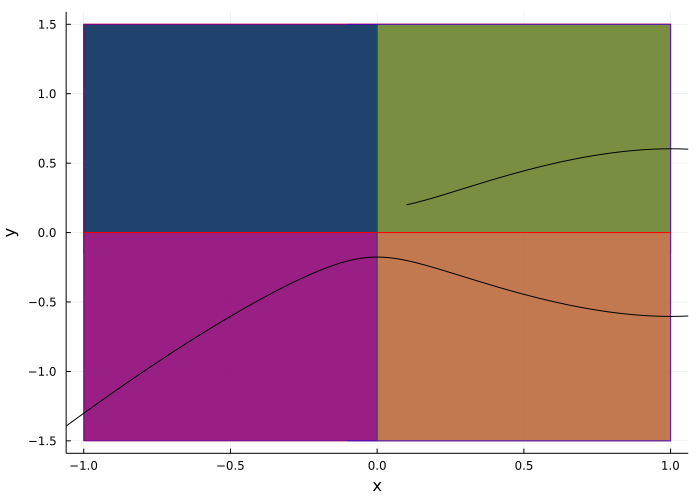

In [4]:
flux2d_nullclines(cuad!,[0.1;0.2],50.0,[0.0];ylims=[-1.5,1.5])

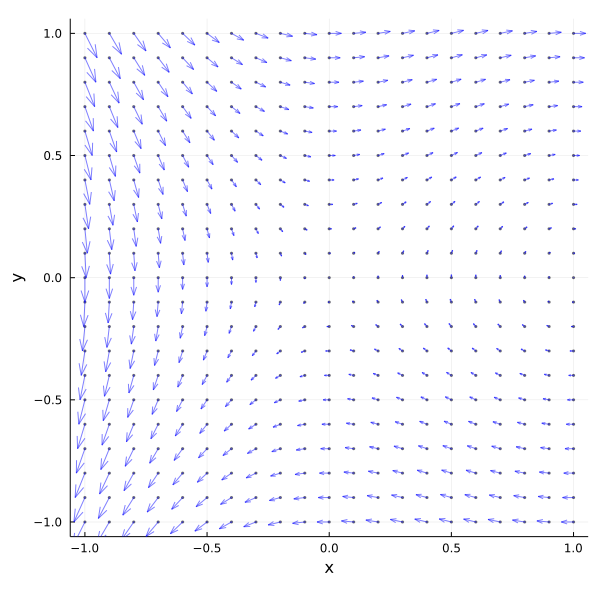

In [5]:
flux2d_vectorfield(cuad!,[0.0])